It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/CNN/cat_vs_dogs.ipynb">
        <img src="https://colab.research.google.com/img/colab_favicon_256px.png"  width="50" height="50" style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/CNN/cat_vs_dogs.ipynb">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png"  width="50" height="50" style="padding-bottom:5px;" />View Source on GitHub</a></td>
</table>

In [7]:
import numpy as np
import tensorflow_datasets as tfds
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
tf.random.set_seed(0)

# Introduction to Tensorflow  Dataset
[Tensorflow tf.data.Dataset tutorial](https://www.tensorflow.org/guide/data)

TensorFlow's tf.data API, which provides a convenient way to create efficient input pipelines for training and evaluation of machine learning models. `tf.data.Dataset` is an abstraction of a
sequence of elements.

The first step to using the tf.data API is creating a Dataset object. Datasets can be created from various sources, including in-memory data, files, or by generating data on-the-fly.

For this example, let's create a dataset from an in-memory NumPy array.

In [8]:
# Create a sample NumPy array
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Create a tf.data Dataset from the NumPy array
dataset = tf.data.Dataset.from_tensor_slices(data)

The `Dataset` object is a Python iterable. This makes it possible to consume its
elements using a for loop:

In [9]:
for elem in dataset:
      print(elem.numpy())

1
2
3
4
5
6
7
8
9
10


Now that we have a dataset, we can apply various transformations to prepare the data for training. Some common transformations include shuffling, batching, and repeating.

**Shuffle**

Randomly shuffles the elements of this dataset.

This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

In [10]:
buffer_size = 2

dataset = dataset.shuffle(buffer_size)

for elem in dataset:
      print(elem.numpy())

2
1
4
3
6
5
7
9
10
8


**Batch**

Combines consecutive elements of this dataset into batches.

In [11]:
batch_size = 2

dataset = dataset.batch(batch_size)

for elem in dataset:
      print(elem.numpy())

[1 3]
[4 5]
[6 2]
[8 7]
[10  9]


In addition to using in-memory data, the `tf.data` API can also read data from files, such as images or text files. For example, let's create a dataset of text lines from a sample file.

In [12]:
# Create a sample text file
with open("sample.txt", "w") as f:
    f.write("This is a sample text file.\n")
    f.write("Each line represents an element in the dataset.\n")
    f.write("We can apply various transformations to the data.\n")
    f.write("This makes it easy to prepare data for training.\n")

# Create a tf.data Dataset from the text file
dataset = tf.data.TextLineDataset("sample.txt")
for elem in dataset:
      print(elem.numpy())

b'This is a sample text file.'
b'Each line represents an element in the dataset.'
b'We can apply various transformations to the data.'
b'This makes it easy to prepare data for training.'


To preprocess the text data, we can apply a map function to the dataset. This allows us to perform arbitrary operations on each element.

In [13]:
# Define a preprocessing function
def preprocess_text(line):
    line = tf.strings.lower(line)
    line = tf.strings.strip(line)
    return line

# Apply the preprocessing function to the dataset
dataset = dataset.map(preprocess_text)

for elem in dataset:
      print(elem.numpy())

b'this is a sample text file.'
b'each line represents an element in the dataset.'
b'we can apply various transformations to the data.'
b'this makes it easy to prepare data for training.'


# Cat vs dog

In [14]:
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
dataset = dataset['train']
class_names = ['cat', 'dog']

size = tf.data.experimental.cardinality(dataset).numpy()
print(f'number of images:{size}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.1E39RD_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
number of images:23262


We need all images to be the same size, we can use [`resize`](https://www.tensorflow.org/api_docs/python/tf/image/resize):

```python
tf.image.resize(
    images, size, method=ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None
)
```


In [15]:
image_size = (96, 96, 3)


def preprocess_img(images, size=(96, 96)):
    return tf.image.resize(images, size)

dataset = dataset.map(lambda images, labels: (preprocess_img(images), labels))

Split the dataset, you can use [different techniques](https://www.tensorflow.org/datasets/splits)

In [16]:
batch_size = 32
train_size = int(0.75 * size)
val_size = int(0.1 * size)

train_ds = dataset.take(train_size)
train_ds = train_ds.shuffle(1000).batch(batch_size).cache()
remaining = dataset.skip(train_size)

val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

val_ds = val_ds.shuffle(1000).batch(batch_size).cache()
test_ds = test_ds.batch(batch_size).cache()

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

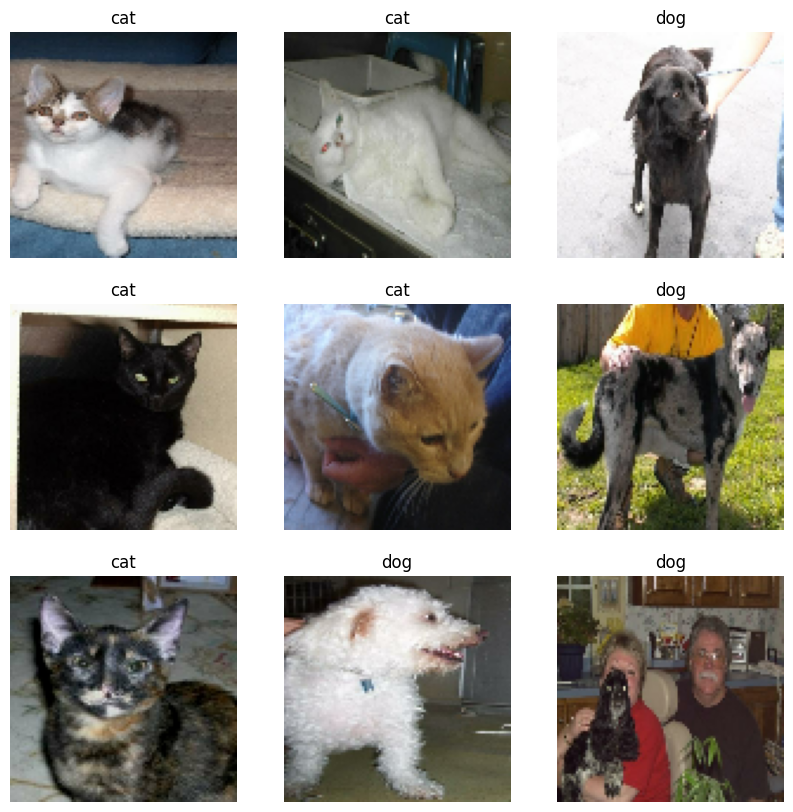

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# CNN model

You can visit the tutorial [Introduction_to_CNN](https://github.com/ezponda/intro_deep_learning/blob/main/class/CNN/Introduction_to_CNN.ipynb)

## CNN model in Keras



<img src="https://raw.githubusercontent.com/ezponda/intro_deep_learning/main/images/cnn.jpeg" alt="cnn" border="0">



A Convolutional Neural Network (CNN) architecture has four main parts:

- A **convolutional layer** that extracts features from a source image.

- A **pooling layer** that reduces the image dimensionality without losing important features or patterns.

- A **flattening layer** that transforms a n-dimensional tensor into a vector that can be fed into a fully connected neural network.

- A **fully connected layer** also known as the dense layer.

### Rescaling

For converting the images to   \[0,1\] range.
```python
normalization_layer = layers.Rescaling(1./255)
next_layer = normalization_layer(prev_layer)
```
or simply
```python
reescaling = layers.Rescaling(1. / 255)(inputs)
```

### Convolutional layer

In the convolutional layers (`Conv2D`) we will configure the following parameters:

- **filters**: number of feature maps.
- **kernel_size**: can be either an integer or a tuple of two integers. Specifies the height and width of the kernel.
- **padding**: allows you to include padding in the input data. With 'valid' it is not applied, with 'same' it is configured so that the dimension at the output of the convolution is the same as at the input.
- **activation**: activation function implemented. Recommended ReLU.

[Link to documentation](https://keras.io/api/layers/convolution_layers/convolution2d/)

```python
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid',
    activation=None, kernel_regularizer=None)

```

With Functional API:
```python
next_layer = layers.Conv2D(filters=8, kernel_size=3, activation='relu', name='conv_1')(prev_layer)
```

With Sequential:
```python
model.add(layers.Conv2D(filters=8,kernel_size=3, activation='relu', name='conv_1'))
```

### Pooling layer

A pooling layer is a new layer added after the convolutional layer. Specifically, after a nonlinearity ( ReLU) you can choose between [average pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D) or [max pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D). Usually max pooling is the best choice.


With Functional API:
```python
conv_1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', name='conv_1')(prev_layer)

pool_1 = layers.MaxPool2D(pool_size=(2, 2), name='pool_1')(conv_1)
```

With Sequential:
```python
model.add(layers.AveragePooling2D(pool_size=(2, 2), name='pool_1'))
```

### Flattening

Prepares a vector for the fully connected layers.

With Functional API:

```python
next_layer = layers.Flatten(name='flatten')(prev_layer)
```

With Sequential:
```python
model.add(layers.Flatten(name='flatten'))
```

There is another alternative for flattening that is a type of pooling that is called global pooling. Global pooling down-samples the entire feature map to a single value.

You can also choose between [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) and [GlobalMaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D).

```python
model.add(layers.GlobalMaxPool2D(name='GlobalMaxPooling2D'))
```

### Fully-connected layer

Dense layer like a simple neural network

## Question 1: Create a model with two convolutional layers without pooling and without any regularization

In [19]:
inputs = tf.keras.Input(shape=image_size, name='input')
reescaling = layers.Rescaling(1./255)(inputs)

# Conv Layer 1
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(reescaling)

# Conv Layer 2
conv_2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(conv_1)

# Fully-connected
# Flattening
flat = layers.Flatten()(conv_2)
dense_1 = layers.Dense(128, activation='relu')(flat)
outputs = layers.Dense(1, activation='sigmoid')(dense_1)

model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [20]:
model_1.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [21]:
epochs = 8

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1)

history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[es_callback]
)

Epoch 1/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.5882 - loss: 1.5083 - val_accuracy: 0.6917 - val_loss: 0.5928
Epoch 2/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.7310 - loss: 0.5257 - val_accuracy: 0.6896 - val_loss: 0.6076
Epoch 3/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.8641 - loss: 0.3139 - val_accuracy: 0.6862 - val_loss: 0.7867
Epoch 3: early stopping


In [48]:
results = model_1.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6825 - loss: 0.7934
Test Loss: 0.7949979901313782
Test Accuracy: 0.6785100102424622


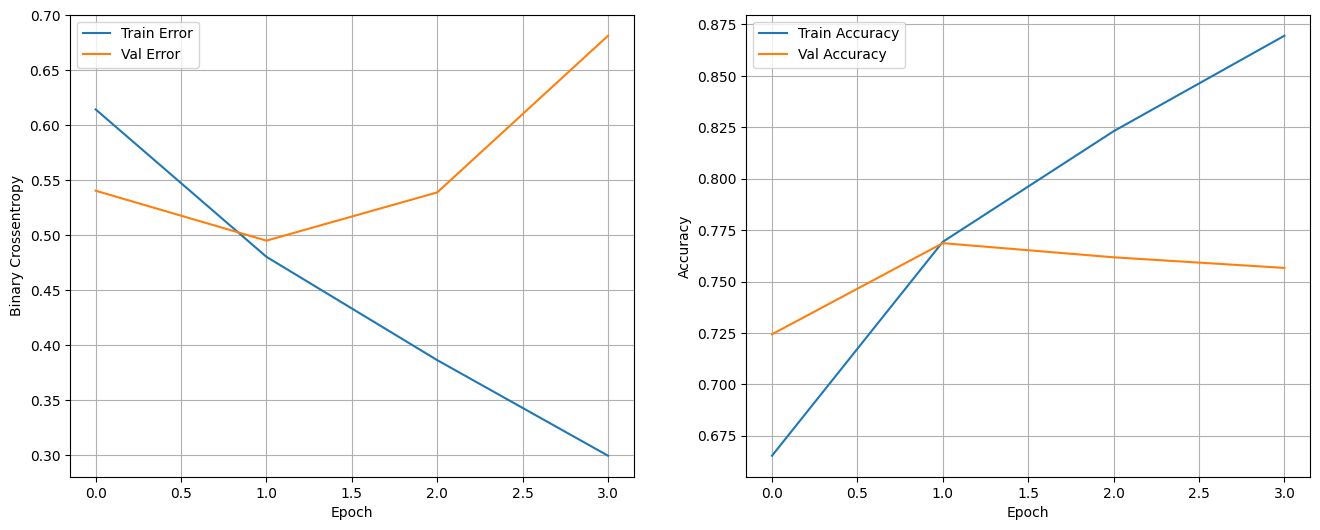

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


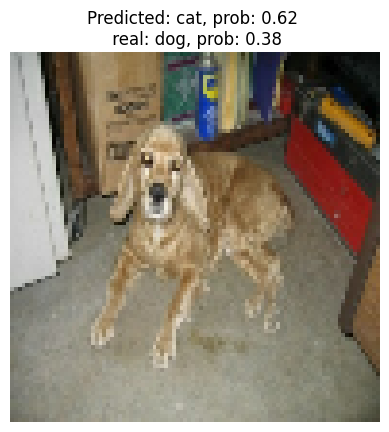

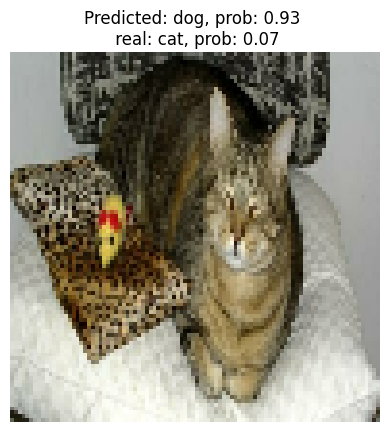

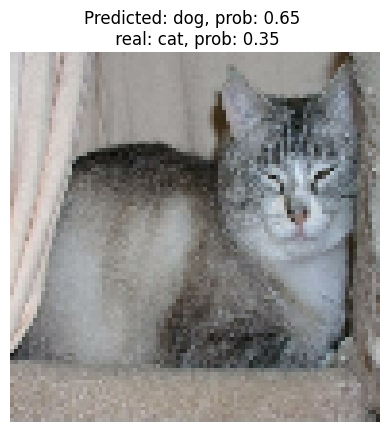

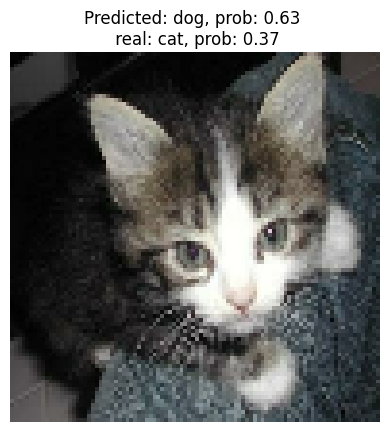

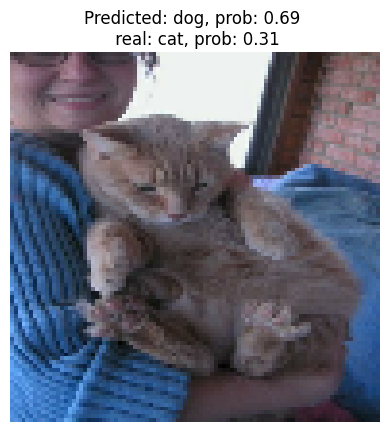


--- Extreme errors (lowest probability for the real class) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

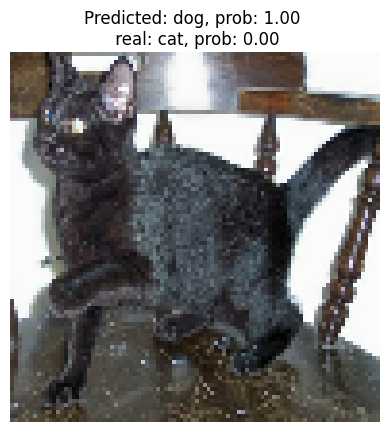

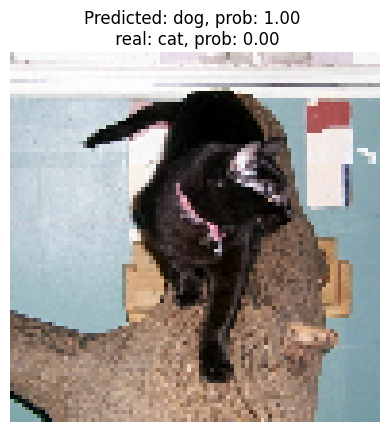

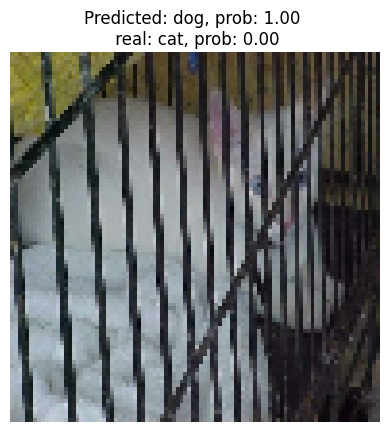

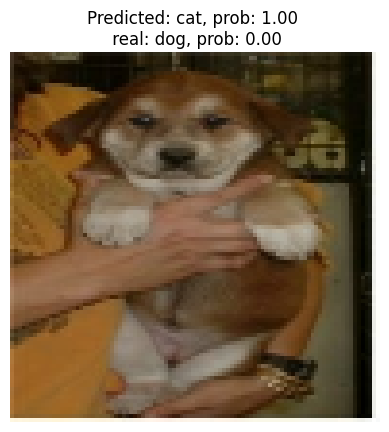

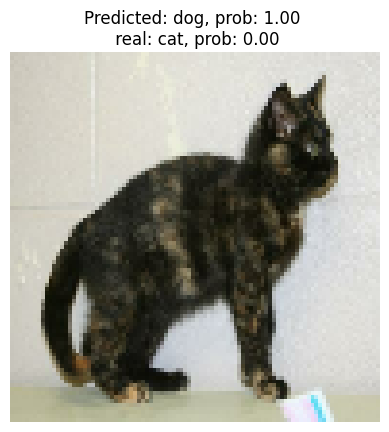

In [49]:
import pandas as pd

def show_loss_accuracy_evolution(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()


def show_errors(val_ds, model, class_names, n_images=10):
    """Display the first n_images misclassified samples."""
    n_plots = 0
    for images, labels in val_ds:
        pred_prob = model.predict(images) # This is P(dog)
        preds = (1.0 * (pred_prob >= 0.5)).astype(np.int32).flatten() # Predicted class (0 or 1)
        bad_pred_inds = np.where(preds != labels)[0]
        for ind in list(bad_pred_inds):
            n_plots += 1
            real_class = class_names[labels[ind].numpy()]
            pred_class = class_names[preds[ind]]

            prob_dog = pred_prob[ind][0] # Probability of being a dog

            # Probability for the predicted class
            prob_pred = prob_dog if preds[ind] == 1 else 1 - prob_dog

            # Probability for the real class
            prob_real = prob_dog if labels[ind].numpy() == 1 else 1 - prob_dog

            plt.imshow(images[ind].numpy().astype("uint8"))
            plt.title('Predicted: {0}, prob: {1:.2f} \n real: {2}, prob: {3:.2f}'.format(
                pred_class, prob_pred, real_class, prob_real))
            plt.axis('off')
            plt.show()

            if n_plots == n_images:
                return


def show_extreme_errors(val_ds, model, class_names, n_images=10):
    """Display the n_images misclassified samples with lowest probability for the real class."""
    errors = []
    for images, labels in val_ds:
        pred_prob = model.predict(images) # This is P(dog)
        preds = (1.0 * (pred_prob >= 0.5)).astype(np.int32).flatten() # Predicted class (0 or 1)
        bad_pred_inds = np.where(preds != labels)[0]
        for ind in bad_pred_inds:
            label = labels[ind].numpy() # Real label (0 or 1)
            prob_dog = pred_prob[ind][0] # Probability of being a dog

            prob_pred = prob_dog if preds[ind] == 1 else 1 - prob_dog # Probability for predicted class
            prob_real = prob_dog if label == 1 else 1 - prob_dog # Probability for real class

            errors.append({
                'image': images[ind].numpy(),
                'real_label': label,
                'pred_label': preds[ind],
                'prob_dog': prob_dog, # Storing P(dog)
                'prob_pred': prob_pred, # Storing P(predicted class)
                'prob_real': prob_real, # Storing P(real class)
            })

    errors.sort(key=lambda x: x['prob_real'])

    for err in errors[:n_images]:
        real_class = class_names[err['real_label']]
        pred_class = class_names[err['pred_label']]
        plt.imshow(err['image'].astype("uint8"))
        plt.title('Predicted: {0}, prob: {1:.2f} \n real: {2}, prob: {3:.2f}'.format(
            pred_class, err['prob_pred'], real_class, err['prob_real']))
        plt.axis('off')
        plt.show()


show_loss_accuracy_evolution(history)
show_errors(test_ds, model_1, class_names, n_images=5)
print('\n--- Extreme errors (lowest probability for the real class) ---')
show_extreme_errors(test_ds, model_1, class_names, n_images=5)

## Question 2: Introduce pooling to the previous model and obtain a better `test_accuracy`, Do not use any regularization

In [60]:
inputs = tf.keras.Input(shape=image_size, name='input')
reescaling = layers.Rescaling(1./255)(inputs)

# Conv Layer 1 + pooling
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(reescaling)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Conv Layer 2 + pooling
conv_2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Fully-connected
# Flattening
flat = layers.Flatten()(pool_2)

outputs = layers.Dense(1, activation='sigmoid')(dense_1)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

ValueError: The name "input" is used 2 times in the model. All operation names should be unique.

In [45]:
model_2.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 8

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1)

history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[es_callback]
)

Epoch 1/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6056 - loss: 0.7194 - val_accuracy: 0.7244 - val_loss: 0.5406
Epoch 2/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7569 - loss: 0.5041 - val_accuracy: 0.7687 - val_loss: 0.4952
Epoch 3/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8140 - loss: 0.4064 - val_accuracy: 0.7618 - val_loss: 0.5391
Epoch 4/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8602 - loss: 0.3214 - val_accuracy: 0.7567 - val_loss: 0.6815
Epoch 4: early stopping


In [50]:
results = model_2.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7452 - loss: 0.7007
Test Loss: 0.6747934818267822
Test Accuracy: 0.7484240531921387


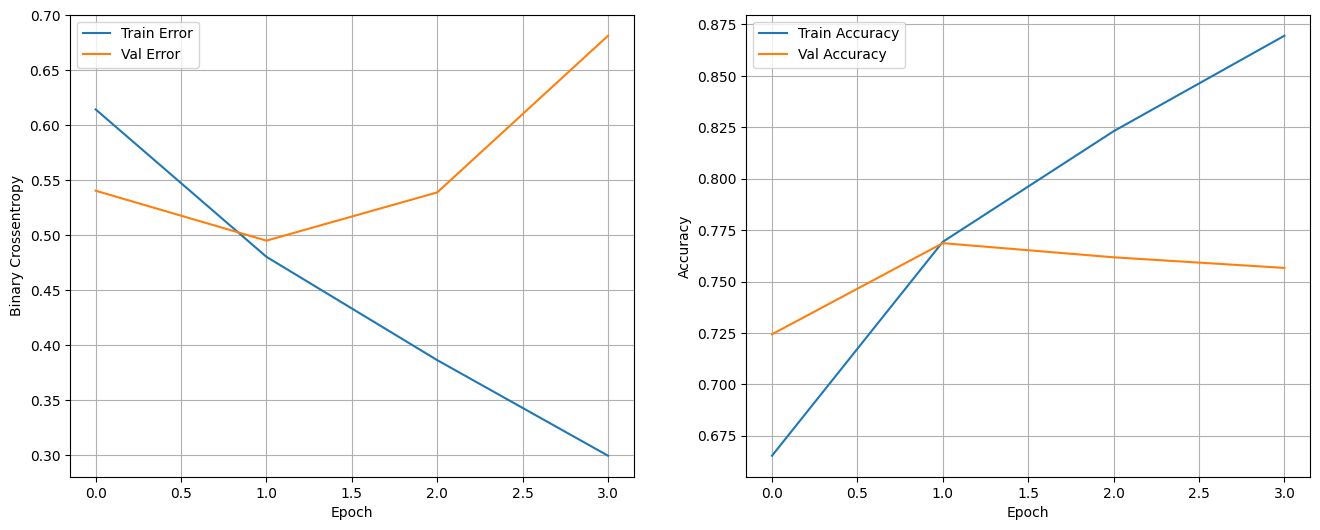

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


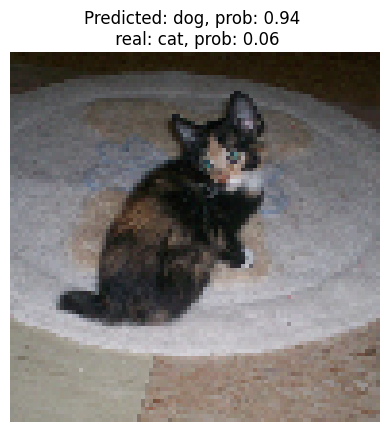

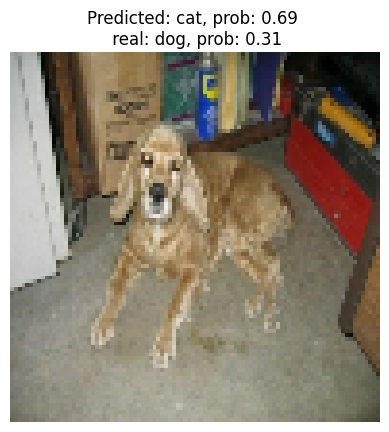

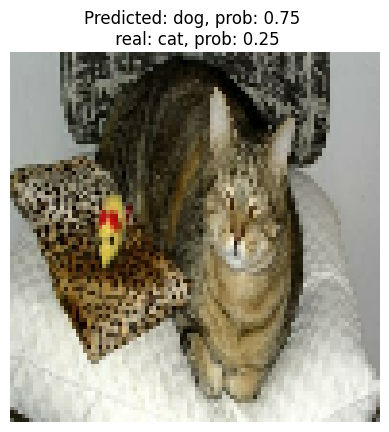

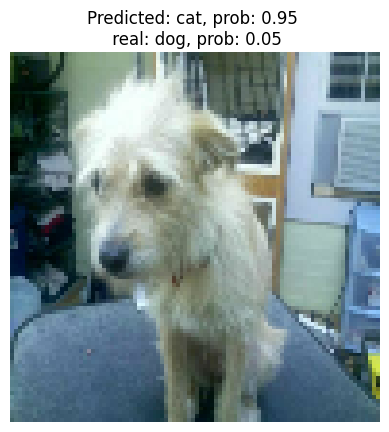

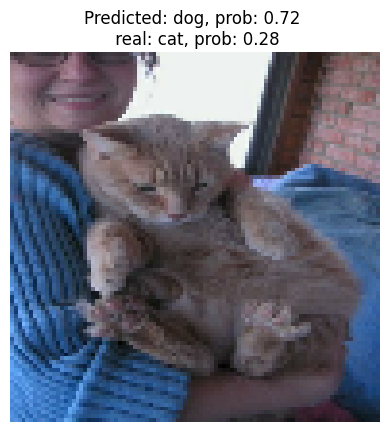


--- Extreme errors (lowest probability for the real class) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

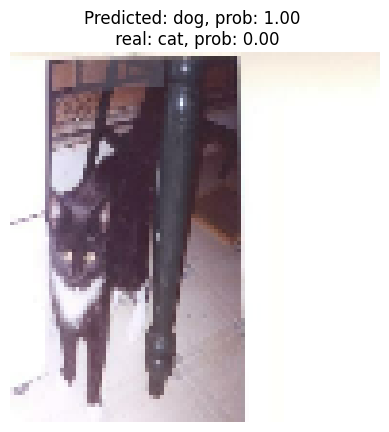

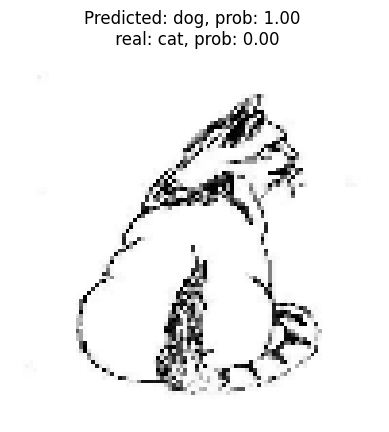

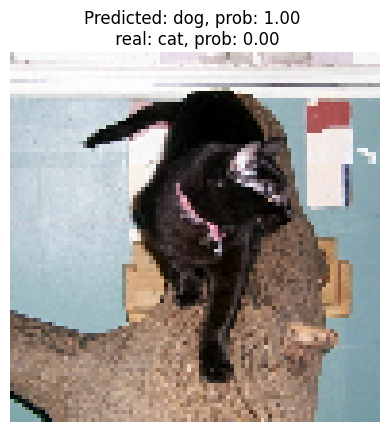

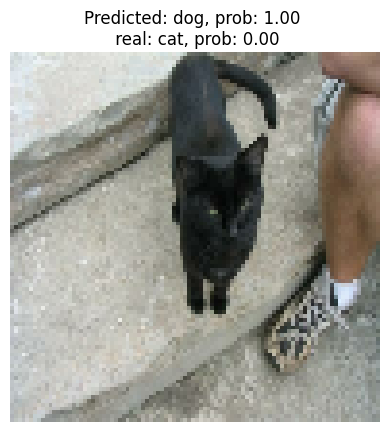

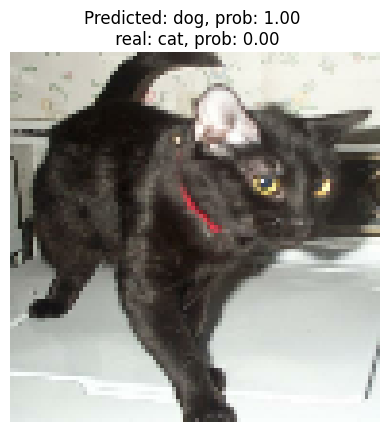

In [51]:
show_loss_accuracy_evolution(history)
show_errors(test_ds, model_2, class_names, n_images=5)
print('\n--- Extreme errors (lowest probability for the real class) ---')
show_extreme_errors(test_ds, model_2, class_names, n_images=5)

## Question 3: Introduce regularization (you can try data augmentation) and increase the number of layers to obtain a better `test_accuracy`. Try to obtain `Test Accuracy > 0.82`



In [62]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandAugment(num_ops=3),
    layers.RandomFlip(),
    layers.RandomRotation(0.25),
  ]
)

In [64]:
inputs = tf.keras.Input(shape=image_size, name='input')

# Data Augmentation layer
x = data_augmentation(inputs)

reescaling = layers.Rescaling(1./255)(x)

# Conv Layer 1 + pooling
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(reescaling)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Conv Layer 2 + pooling
conv_2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# New Conv Layer 3 + pooling
conv_3 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(pool_2)
pool_3 = layers.MaxPool2D(pool_size=(2, 2))(conv_3)

# Fully-connected
# Flattening
flat = layers.Flatten()(pool_3)
dense_1 = layers.Dense(128, activation='relu')(flat)
dropout_1 = layers.Dropout(0.5)(dense_1) # Dropout para regularización
outputs = layers.Dense(1, activation='sigmoid')(dropout_1)

model_3 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [65]:
model_3.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 15 # Aumentamos las épocas ya que el modelo es más complejo y tiene regularización

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3, # Aumentamos la paciencia para permitir más tiempo de mejora
    verbose=1)

history = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[es_callback]
)

Epoch 1/15
546/546 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.5367 - loss: 0.6880 - val_accuracy: 0.6402 - val_loss: 0.6283
Epoch 2/15
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.6711 - loss: 0.6109 - val_accuracy: 0.6410 - val_loss: 0.6283
Epoch 3/15
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.6912 - loss: 0.5902 - val_accuracy: 0.6634 - val_loss: 0.6066
Epoch 4/15
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.6989 - loss: 0.5740 - val_accuracy: 0.6806 - val_loss: 0.6010
Epoch 5/15
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.7060 - loss: 0.5658 - val_accuracy: 0.6973 - val_loss: 0.5727
Epoch 6/15
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.7169 - loss: 0.5528 - val_accuracy: 0.7236 - val_loss: 0.5471
Epoch 7/15
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.7316 - loss: 0.5419 - val_accuracy: 0.7313 - val_loss: 0.5351
Epoch 8/15
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.7370 - loss: 0.5296 - 

In [66]:
results = model_3.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7750 - loss: 0.4689
Test Loss: 0.4837881624698639
Test Accuracy: 0.764756441116333


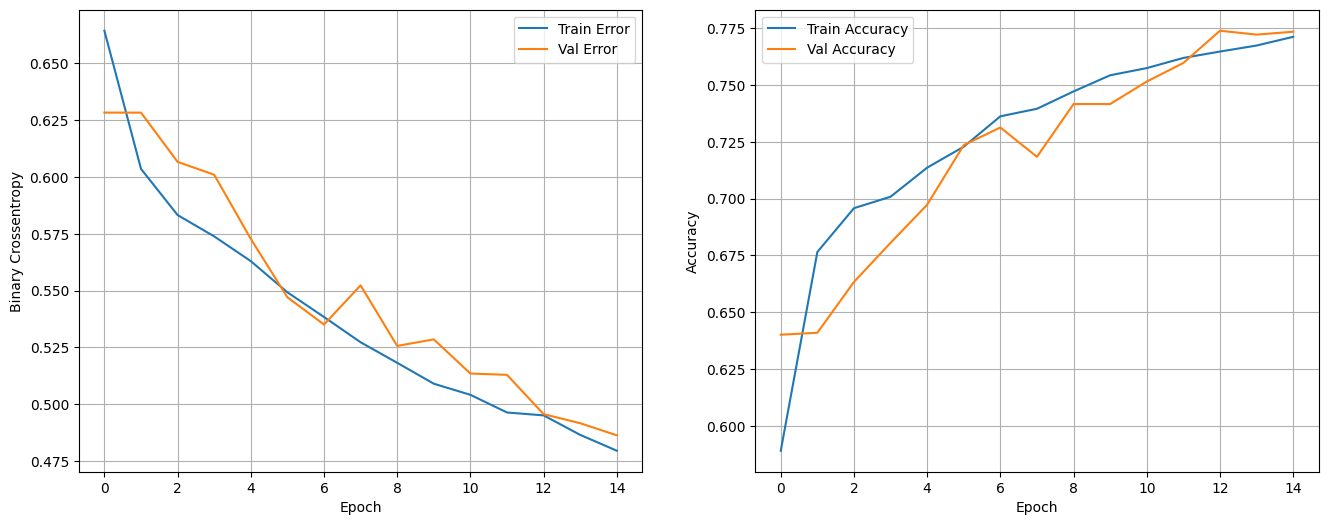

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


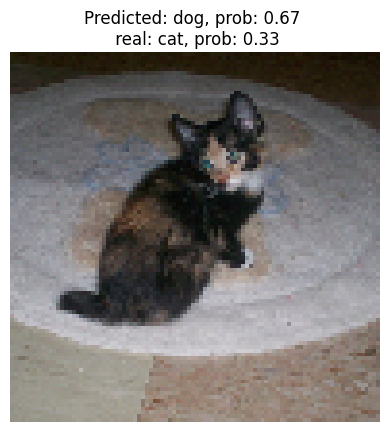

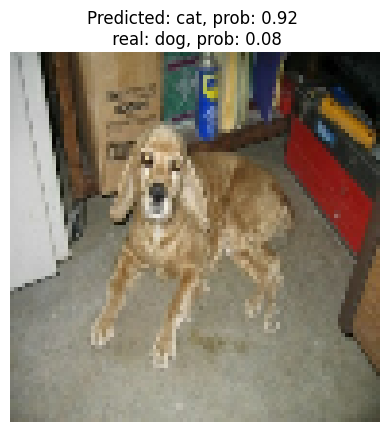

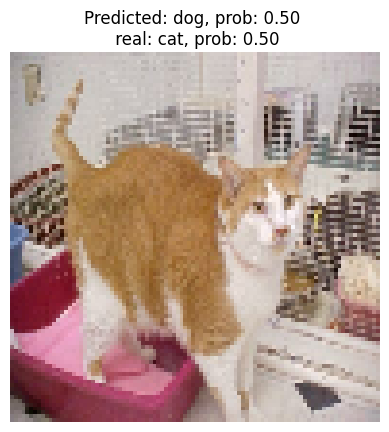

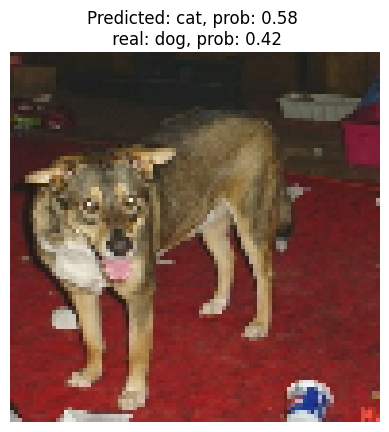

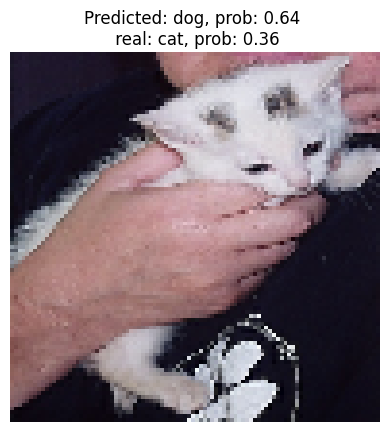


--- Extreme errors (lowest probability for the real class) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

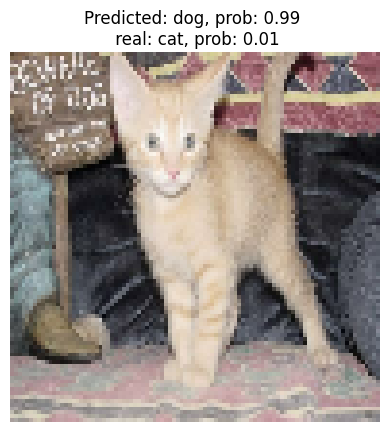

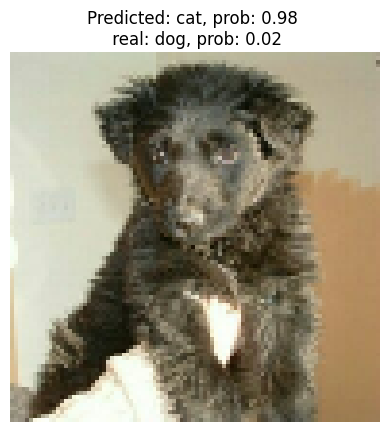

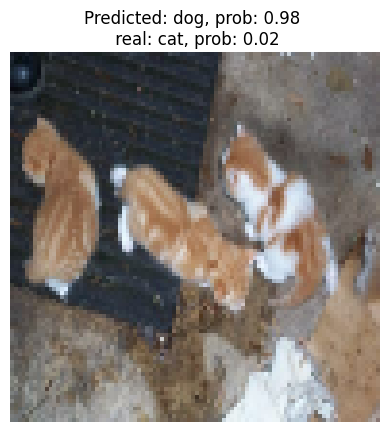

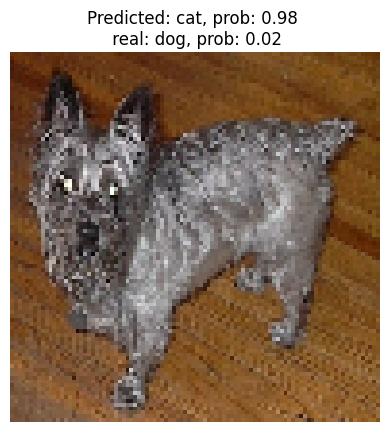

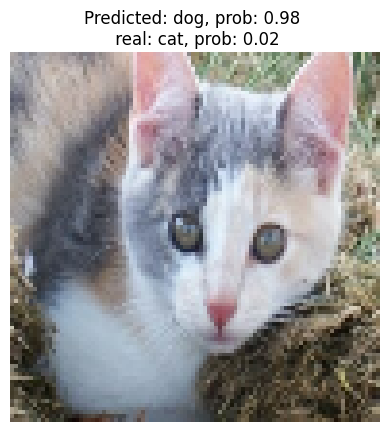

In [67]:
show_loss_accuracy_evolution(history)
show_errors(test_ds, model_3, class_names, n_images=5)
print('\n--- Extreme errors (lowest probability for the real class) ---')
show_extreme_errors(test_ds, model_3, class_names, n_images=5)

## Question 3.1 (Optional): Tune a CNN Architecture with Keras Tuner

[Keras Tuner tutorial](https://github.com/ezponda/intro_deep_learning/blob/main/class/Fundamentals/Regression_tuner.ipynb) :

Hyperparameters are of two types:
1. **Model hyperparameters** like number of units, type of activation or number hidden layers.
2. **Algorithm hyperparameters** like the learning rate in adam.

The model-building function takes an argument `hp` from which you can sample hyper-parameters.

```python
def build_model(hp):
    ...
    return model

```

- `hp.Int` to sample an integer from a certain range:
```python
hp.Int('units', min_value=32, max_value=256, step=32, default=64)
```
- `hp.Float` to sample a float number from a certain range:
```python
hp.Float('dropout', min_value=0.0, max_value=0.1, default=0.005, step=0.05)
```
- `hp.Choice` to select values in a list:
```python
hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
```
- [list of hyperparameter methods](https://keras-team.github.io/keras-tuner/documentation/hyperparameters/)

In [68]:
#!pip install -U keras-tuner

In [34]:
import keras_tuner as kt

In [35]:
def build_cnn_model(hp):
    """Build a CNN model with tunable architecture and dropout regularization using Functional API."""
    inputs = keras.Input(shape=image_size)

    # Start the model flow with the inputs
    x = layers.Rescaling(1. / 255)(inputs)

    # Tune the number of convolutional blocks (try 1-3 blocks)
    for i in range(hp.Int('num_conv_blocks', min_value=1, max_value=3)):
        # Tune the number of filters in each Conv2D layer
        x = layers.Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=16, max_value=128, step=16),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation='relu',
            padding='same'
        )(x)

        # Add dropout after the Conv2D layer
        x = layers.Dropout(
            hp.Float(f'conv_dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        )(x)

        # Add pooling layer
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten layer before dense layers
    x = layers.Flatten()(x)

    x = layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    )(x)

    x = layers.Dropout(
        hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1)
    )(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [36]:
tuner = kt.RandomSearch(build_cnn_model,
                     objective='val_loss',
                     max_trials=2,
                     directory='my_dir',
                     project_name='intro_to_kt')

# Early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Start the search
tuner.search(
    train_ds,  # Use your TensorFlow dataset
    validation_data=val_ds,
    epochs=10,
    callbacks=[es_callback]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 2 Complete [00h 02m 08s]
val_loss: 0.4990728199481964

Best val_loss So Far: 0.4990728199481964
Total elapsed time: 00h 03m 52s


In [37]:
# Print the optimal architecture
print(f"Best number of convolutional blocks: {best_hps.get('num_conv_blocks')}")
for i in range(best_hps.get('num_conv_blocks')):
    print(f"Conv block {i+1}:")
    print(f"  - Filters: {best_hps.get(f'filters_{i}')}")
    print(f"  - Kernel size: {best_hps.get(f'kernel_size_{i}')}")
    print(f"  - Dropout rate: {best_hps.get(f'conv_dropout_{i}')}")

print(f"Dense layer units: {best_hps.get('dense_units')}")
print(f"Dense layer dropout: {best_hps.get('dense_dropout')}")

Best number of convolutional blocks: 2
Conv block 1:
  - Filters: 64
  - Kernel size: 5
  - Dropout rate: 0.30000000000000004
Conv block 2:
  - Filters: 112
  - Kernel size: 3
  - Dropout rate: 0.2
Dense layer units: 96
Dense layer dropout: 0.30000000000000004


In [38]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 112)    │        64,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48, 48, 112)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 112)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64512)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │     6,193,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,262,833 (23.89 MB)

 Trainable params: 6,262,833 (23.89 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:

# Train the model
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[es_callback]
)

# Evaluate on test dataset
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.5714 - loss: 0.7506 - val_accuracy: 0.6578 - val_loss: 0.6218
Epoch 2/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.6845 - loss: 0.5941 - val_accuracy: 0.7291 - val_loss: 0.5711
Epoch 3/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.7330 - loss: 0.5311 - val_accuracy: 0.7489 - val_loss: 0.5232
Epoch 4/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.7816 - loss: 0.4629 - val_accuracy: 0.7377 - val_loss: 0.5144
Epoch 5/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8281 - loss: 0.3808 - val_accuracy: 0.7597 - val_loss: 0.5151
Epoch 6/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8631 - loss: 0.3097 - val_accuracy: 0.7524 - val_loss: 0.5404
Epoch 7/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8918 - loss: 0.2570 - val_accuracy: 0.7352 - val_loss: 0.6008
Epoch 8/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9199 - loss: 0.2038 - 

## Question 4: Try transfer learning

You can use pre-trained models from [`tf.keras.applications`](https://keras.io/api/applications/#available-models). With `include_top=False` you remove the classification head and get the feature maps. With `trainable = False` you freeze the pre-trained weights.

Each model has its own `preprocess_input` function. For example, MobileNetV2 expects inputs normalized to `[-1, 1]` (not `[0, 1]` like `Rescaling(1./255)`).

In [56]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=image_size,
                                                     include_top=False)
pretrained_model.trainable = False

In [41]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [57]:
inputs = tf.keras.Input(shape=image_size, name='input')

# pre-trained model
x = preprocess_input(inputs)
x = pretrained_model(x)

# classifier
flat = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(128, activation='relu')(flat) # Añadimos una capa densa antes de la salida
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model_tl = tf.keras.Model(inputs, outputs)
model_tl.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,732,801 (14.24 MB)

 Trainable params: 1,474,817 (5.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [69]:
model_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 2

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1)

history = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[es_callback]
)

Epoch 1/2
546/546 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.9755 - loss: 0.1006 - val_accuracy: 0.9609 - val_loss: 0.1569
Epoch 2/2
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9860 - loss: 0.0443 - val_accuracy: 0.9592 - val_loss: 0.1518


In [70]:
results = model_tl.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.9630 - loss: 0.1243
Test Loss: 0.14203619956970215
Test Accuracy: 0.9618911147117615


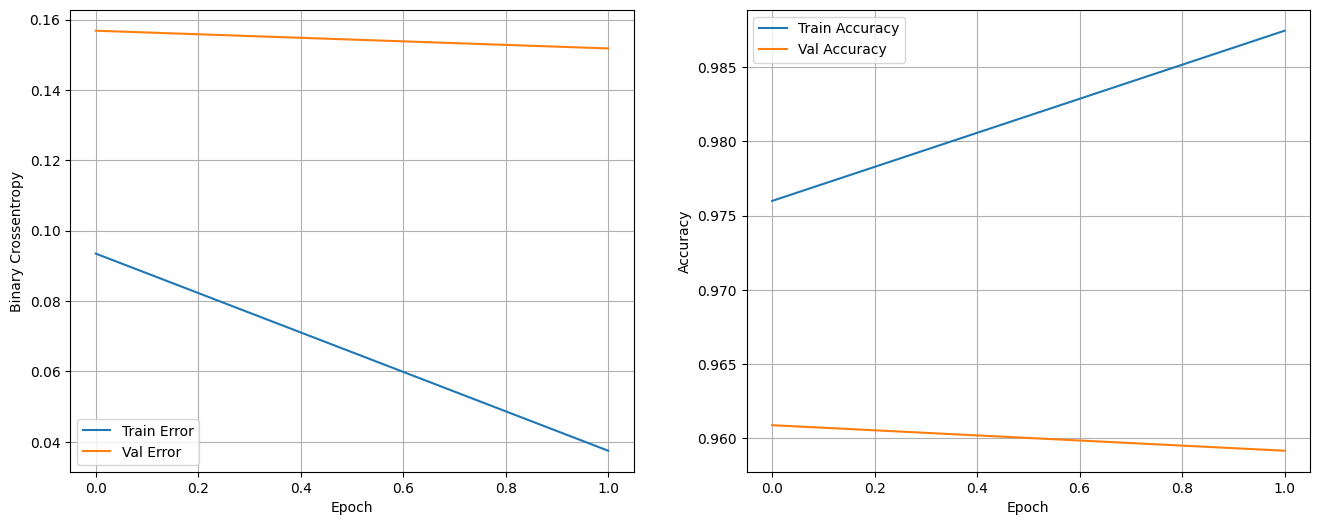

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


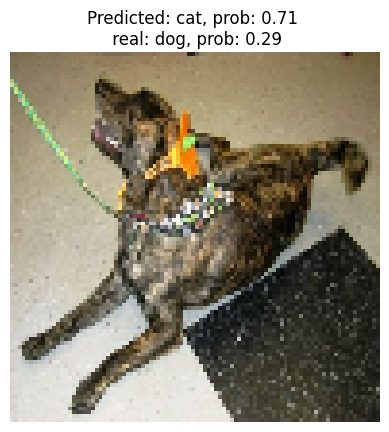

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


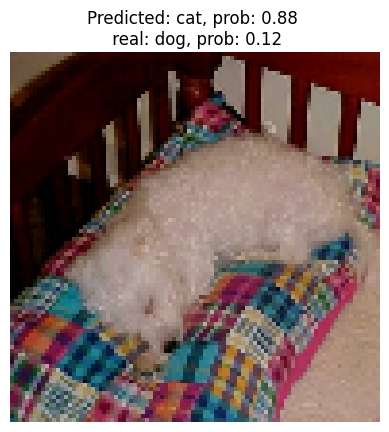

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


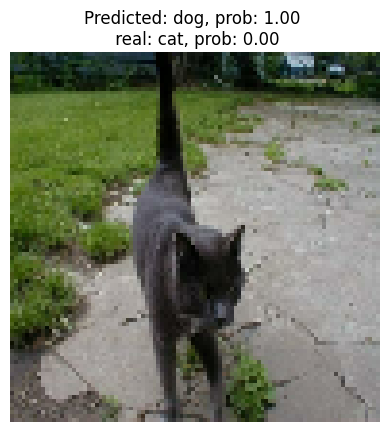

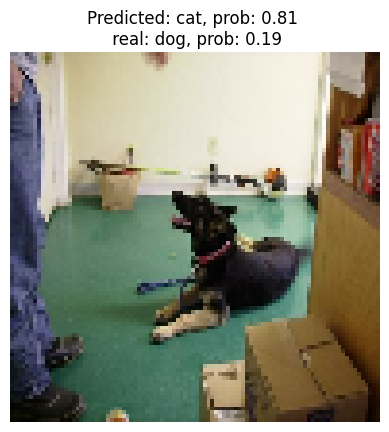

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


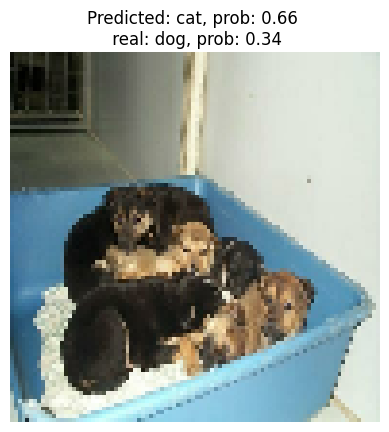


--- Extreme errors (lowest probability for the real class) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

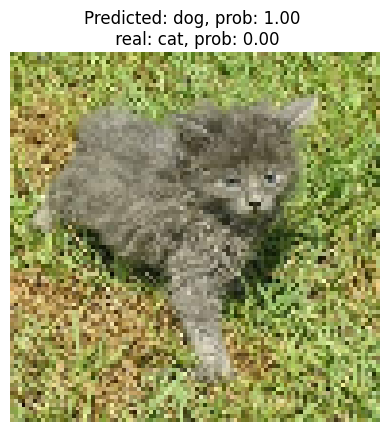

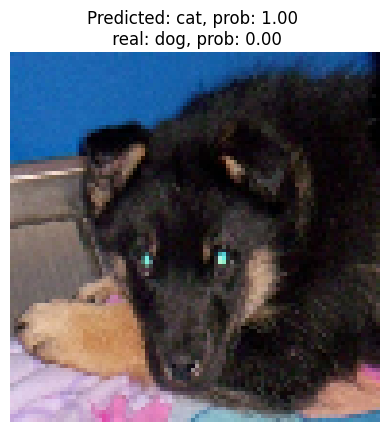

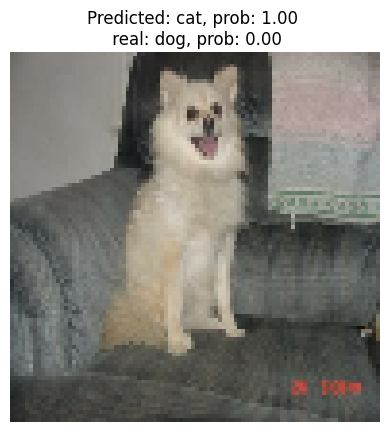

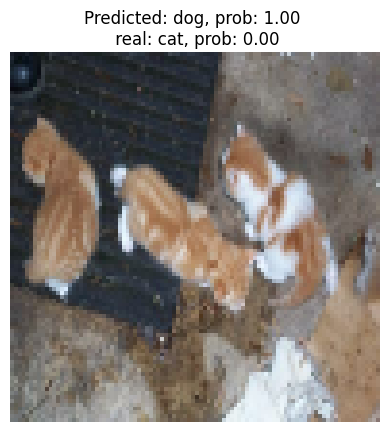

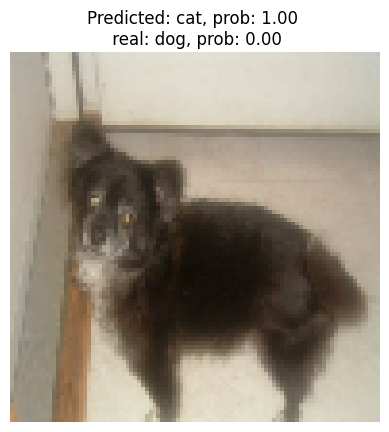

In [71]:
show_loss_accuracy_evolution(history)
show_errors(test_ds, model_tl, class_names, n_images=5)
print('\n--- Extreme errors (lowest probability for the real class) ---')
show_extreme_errors(test_ds, model_tl, class_names, n_images=5)

# Generalization

In [72]:
def read_image(image_path, target_size=None):
    image = tf.keras.preprocessing.image.load_img(image_path,
                target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image.astype(np.uint8)
    return image

def predict_plot(image_path, model, class_names, image_size):
    image = read_image(image_path, image_size[:2])
    prob = model.predict(np.expand_dims(image, 0))[0][0]
    pred_class = class_names[(1.0 * (prob >= 0.5)).astype(np.int32)]
    plt.imshow(image)
    plt.title(
        'Predicted: {0}, prob: {1:.2f}'
        .format(pred_class, prob))
    plt.axis('off')
    plt.show()

48769/48769 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
model 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


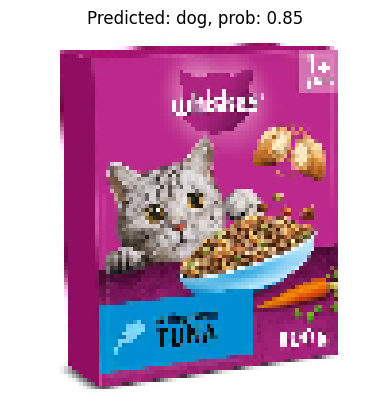

model 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


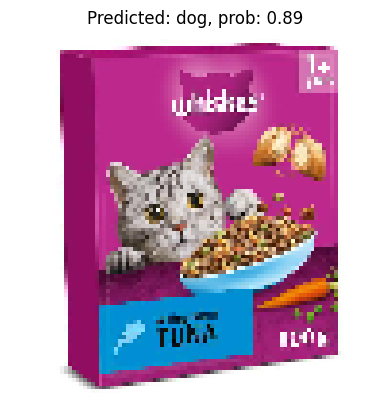

model 3


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


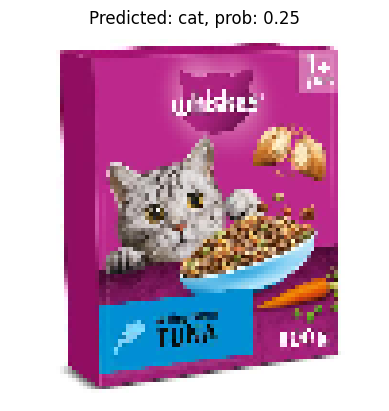

model tl


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


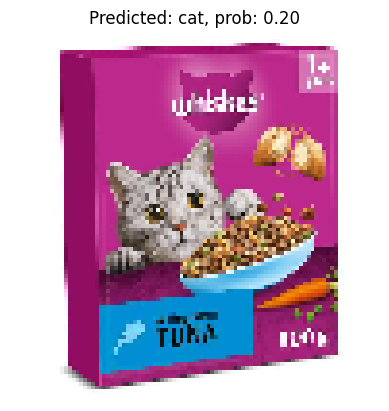

In [73]:
url = 'https://raw.githubusercontent.com/ezponda/intro_deep_learning/main/images/dog_vs_cat_1.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_1.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)

29181/29181 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
model 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


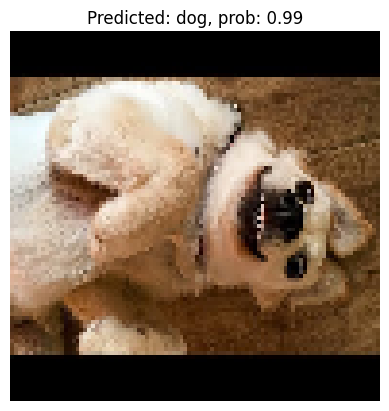

model 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


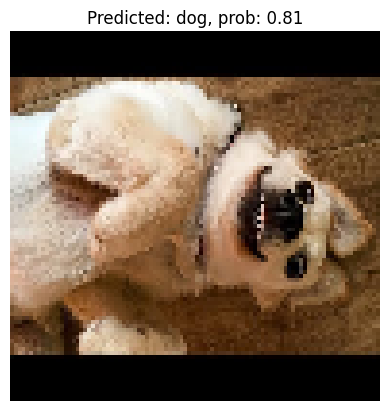

model 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


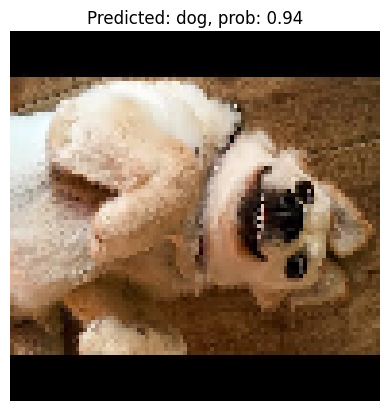

model tl
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


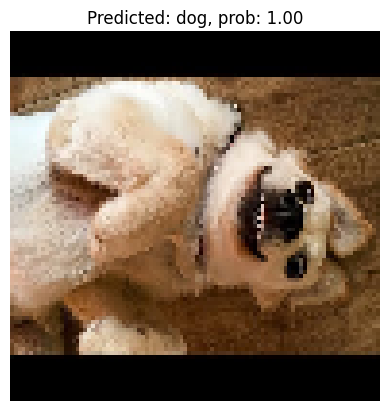

In [74]:
url = 'https://raw.githubusercontent.com/ezponda/intro_deep_learning/main/images/dog_vs_cat_2.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_2.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)

31623/31623 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
model 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


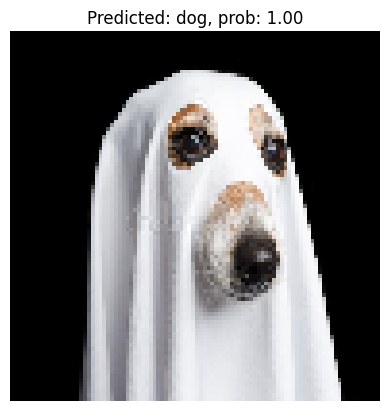

model 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


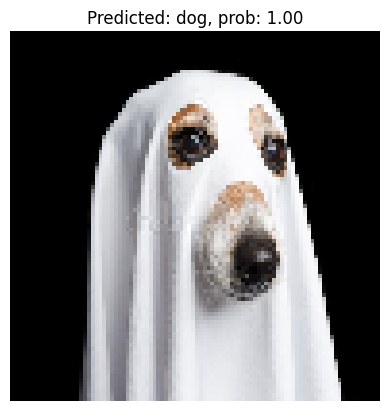

model 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


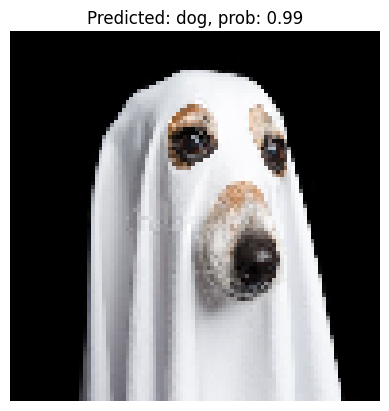

model tl
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


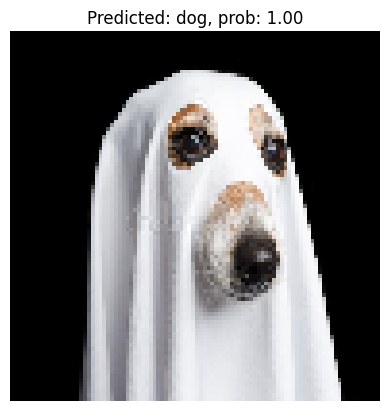

In [75]:
url = 'https://raw.githubusercontent.com/ezponda/intro_deep_learning/main/images/dog_vs_cat_3.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_3.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)